In [92]:
import re
from collections import Counter

# get only text from train input data
print("TRAIN + DEV")
with open("data/train/in.tsv", 'r') as f:
    train_lines = [line for line in f.read().split('\n') if line.strip()]
with open("data/dev-0/in.tsv", 'r') as f:
    dev_lines = [line for line in f.read().split('\n') if line.strip()]

lines = train_lines + dev_lines
lines = [line.split("\t") for line in lines]

sources = list(zip(*lines))[0]
texts_ts = list(zip(*lines))[2]

texts = [re.sub(r':\d+-\d+', '', text) for text in texts_ts] # remove timestamps

print(len(texts), "sentences\n", len(set(sources)), "audio files")
texts[:5]



TRAIN + DEV
11010 sentences
 69 audio files


['I teraz mamy drugi dzień takiej ładnej pogody Ała Nie bij mnie kijem To boli',
 'Stasio Bo nie dostaniesz jogurciku',
 'Jogurcik dostają tylko grzeczne dzieci Które nie biją mamy kijem',
 'Nie biją',
 'Uhm A co powiesz jak wejdziesz do sklepu']

In [2]:
# get labels
train_labels = open("data/train/expected.tsv", "r").readlines()
dev_labels = open("data/dev-0/expected.tsv", "r").readlines()
labels = train_labels + dev_labels
labels = [label.replace("\n", "") for label in labels]

len(labels)
list(zip(texts, labels))[:5]

[('I teraz mamy drugi dzień takiej ładnej pogody Ała Nie bij mnie kijem To boli',
  'I teraz mamy drugi dzień takiej ładnej pogody... Ała! Nie bij mnie kijem! To boli!'),
 ('Stasio Bo nie dostaniesz jogurciku',
  'Stasio! Bo nie dostaniesz jogurciku!'),
 ('Jogurcik dostają tylko grzeczne dzieci Które nie biją mamy kijem',
  'Jogurcik dostają tylko grzeczne dzieci. Które nie biją mamy kijem.'),
 ('Nie biją', 'Nie biją.'),
 ('Uhm A co powiesz jak wejdziesz do sklepu',
  'Uhm. A co powiesz, jak wejdziesz do sklepu?')]

min:  1 
max:  184 
avg:  8.909627611262488 
all:  98095


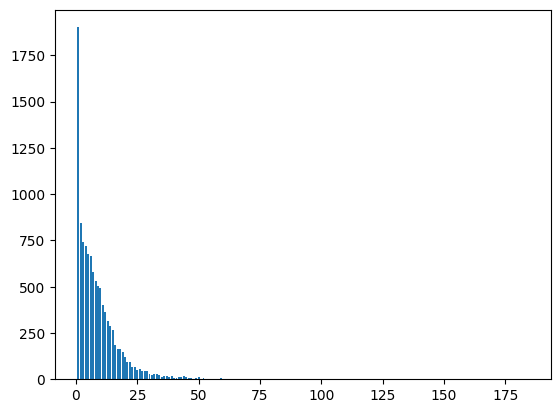

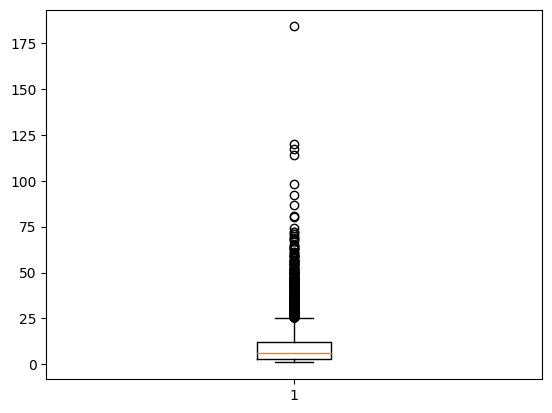

In [19]:
import matplotlib.pyplot as plt
# number of words
lengths = [len(text.split()) for text in texts]
print("min: ", min(lengths), "\nmax: ", max(lengths), "\navg: ", sum(lengths) / len(lengths), "\nall: ", sum(lengths))
plt.bar(Counter(lengths).keys(), Counter(lengths).values());
plt.show()
plt.boxplot(lengths);

In [4]:
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
%matplotlib inline

def punctuation_stats(labels):  
    labels = [label.replace("...", '…') for label in labels]
    puncts = [re.sub(r'\w|\s', '', label) for label in labels]
    puncts_number = Counter("".join(puncts)).most_common()
    print("total punctuation count:")
    pprint(puncts_number)

    counts = np.zeros((len(puncts_number), len(labels)))
    for i, label in enumerate(labels):
        for j, punct in enumerate(puncts_number):
            counts[j, i] = label.count(punct[0])

    plt.figure(figsize=(10,50))
    plt.imshow(counts[:, :50], cmap='gray')
    plt.yticks(range(len(puncts_number)), [punct[0] for punct in puncts_number]);

    stats = [["", "min", "max", "mean", "std"]] + list(zip([punct[0] for punct in puncts_number], counts.min(axis=1), counts.max(axis=1), counts.mean(axis=1), counts.std(axis=1)))
    print("stats for sentences")
    pprint(stats)

total punctuation count:
[(',', 11141),
 ('.', 7785),
 ('…', 4519),
 ('?', 1659),
 ('!', 247),
 ('-', 166),
 ('@', 1)]
stats for sentences
[['', 'min', 'max', 'mean', 'std'],
 (',', 0.0, 19.0, 1.0118982742960945, 1.6335893326434152),
 ('.', 0.0, 10.0, 0.7070844686648501, 0.7885619311731719),
 ('…', 0.0, 11.0, 0.41044504995458675, 0.9531342636514238),
 ('?', 0.0, 4.0, 0.15068119891008175, 0.40713659634611926),
 ('!', 0.0, 3.0, 0.022434150772025433, 0.18018528277052606),
 ('-', 0.0, 3.0, 0.015077202543142598, 0.13256951439506232),
 ('@', 0.0, 1.0, 9.082652134423252e-05, 0.009529862112709345)]


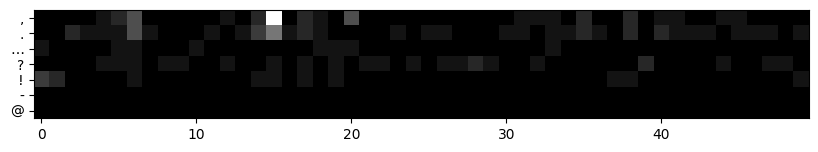

In [5]:
punctuation_stats(labels) # In gold labels

total punctuation count:
[('-', 115), ('…', 49), ("'", 15), ('@', 1), ('.', 1)]
stats for sentences
[['', 'min', 'max', 'mean', 'std'],
 ('-', 0.0, 3.0, 0.01044504995458674, 0.10941128036098066),
 ('…', 0.0, 2.0, 0.004450499545867393, 0.07053829972238501),
 ("'", 0.0, 1.0, 0.0013623978201634877, 0.03688552144599695),
 ('@', 0.0, 1.0, 9.082652134423252e-05, 0.009529862112709345),
 ('.', 0.0, 1.0, 9.082652134423252e-05, 0.009529862112709345)]


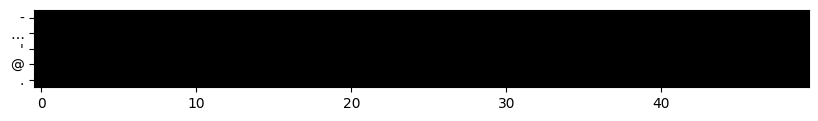

In [6]:
punctuation_stats(texts) # In raw text

In [7]:
# Add duration for each word

import re
times = []
matches = re.findall(r':\d+-\d+', texts_ts[0])
for match in matches:
    match = match[1:].split("-")
    times.append(int(match[1]) - int(match[0]))

text_dur = list(zip(texts[0].split(" "), times))
text_dur = [str(x) for t in text_dur for x in t]
" ".join(text_dur)

'I 0 teraz 240 mamy 120 drugi 420 dzień 120 takiej 240 ładnej 210 pogody 570 Ała 0 Nie 60 bij 120 mnie 210 kijem 420 To 60 boli 90'

# herbert

In [9]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [8]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

encoded_input = tokenizer.encode("Who is the best is the best", return_tensors="pt")
outputs = model(encoded_input)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
TOKEN_IDX = {
    'bert': {
        'START_SEQ': 101,
        'PAD': 0,
        'END_SEQ': 102,
        'UNK': 100
    },
    'xlm': {
        'START_SEQ': 0,
        'PAD': 2,
        'END_SEQ': 1,
        'UNK': 3
    },
    'roberta': {
        'START_SEQ': 0,
        'PAD': 1,
        'END_SEQ': 2,
        'UNK': 3
    },
    'albert': {
        'START_SEQ': 2,
        'PAD': 0,
        'END_SEQ': 3,
        'UNK': 1
    },
}


TOKEN_STYLE = 'xlm'

file_path = "punctuation-restoration-master/data/en/dev2012"
sequence_len = 25
token_style = 'xlm'
# 'O' -> No punctuation
punctuation_dict = {'O': 0, 'COMMA': 1, 'PERIOD': 2, 'QUESTION': 3}

# x – all tokens for the word, no punctuation, special tokens in the beginning and end (e.g. ["ad", "#am"])
# y – 0 for all tokens for the word, then punctuation (e.g. [0, 0, 0])
# y_mask – mask for the punctuation tokens (1 if punctuation, 0 otherwise) (e.g. [0, 0, 1])
# attn_mask – mask for the padding tokens (1 if not padding, 0 otherwise) (e.g. [1, 1, 1])

In [ ]:

def parse_data(file_path, tokenizer, sequence_len, token_style):
    """

    :param file_path: text file path that contains tokens and punctuations separated by tab in lines
    :param tokenizer: tokenizer that will be used to further tokenize word for BERT like models
    :param sequence_len: maximum length of each sequence
    :param token_style: For getting index of special tokens in config.TOKEN_IDX
    :return: list of [tokens_index, punctuation_index, attention_masks, punctuation_mask], each having sequence_len
    punctuation_mask is used to ignore special indices like padding and intermediate sub-word token during evaluation
    """
    data_items = []
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line for line in f.read().split('\n') if line.strip()]
        idx = 0
        # loop until end of the entire text
        while idx < len(lines):
            x = [TOKEN_IDX[token_style]['START_SEQ']]
            y = [0]
            y_mask = [1]  # which positions we need to consider while evaluating i.e., ignore pad or sub tokens

            # loop until we have required sequence length
            # -1 because we will have a special end of sequence token at the end
            while len(x) < sequence_len - 1 and idx < len(lines):
                word, punc = lines[idx].split('\t')
                tokens = tokenizer.tokenize(word)
                # if taking these tokens exceeds sequence length we finish current sequence with padding
                # then start next sequence from this token
                if len(tokens) + len(x) >= sequence_len:
                    break
                else:
                    for i in range(len(tokens) - 1):
                        x.append(tokenizer.convert_tokens_to_ids(tokens[i]))
                        y.append(0)
                        y_mask.append(0)
                    if len(tokens) > 0:
                        x.append(tokenizer.convert_tokens_to_ids(tokens[-1]))
                    else:
                        x.append(TOKEN_IDX[token_style]['UNK'])
                    y.append(punctuation_dict[punc])
                    y_mask.append(1)
                    idx += 1
            x.append(TOKEN_IDX[token_style]['END_SEQ'])
            y.append(0)
            y_mask.append(1)
            if len(x) < sequence_len:
                x = x + [TOKEN_IDX[token_style]['PAD'] for _ in range(sequence_len - len(x))]
                y = y + [0 for _ in range(sequence_len - len(y))]
                y_mask = y_mask + [0 for _ in range(sequence_len - len(y_mask))]
            attn_mask = [1 if token != TOKEN_IDX[token_style]['PAD'] else 0 for token in x]
            data_items.append([x, y, attn_mask, y_mask])
    return data_items

In [ ]:
word, punc = lines[0].split('\t')
tokens = tokenizer.tokenize(word)
tokenizer.convert_tokens_to_ids(tokens[0])

In [ ]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, files, tokenizer, sequence_len, token_style, is_train=False, augment_rate=0.1,
                 augment_type='substitute'):
        """

        :param files: single file or list of text files containing tokens and punctuations separated by tab in lines
        :param tokenizer: tokenizer that will be used to further tokenize word for BERT like models
        :param sequence_len: length of each sequence
        :param token_style: For getting index of special tokens in config.TOKEN_IDX
        :param augment_rate: token augmentation rate when preparing data
        :param is_train: if false do not apply augmentation
        """
        if isinstance(files, list):
            self.data = []
            for file in files:
                self.data += parse_data(file, tokenizer, sequence_len, token_style)
        else:
            self.data = parse_data(files, tokenizer, sequence_len, token_style)
        self.sequence_len = sequence_len
        self.augment_rate = augment_rate
        self.token_style = token_style
        self.is_train = is_train
        self.augment_type = augment_type

    def __len__(self):
        return len(self.data)

    def _augment(self, x, y, y_mask):
        x_aug = []
        y_aug = []
        y_mask_aug = []
        for i in range(len(x)):
            r = np.random.rand()
            if r < self.augment_rate:
                AUGMENTATIONS[self.augment_type](x, y, y_mask, x_aug, y_aug, y_mask_aug, i, self.token_style)
            else:
                x_aug.append(x[i])
                y_aug.append(y[i])
                y_mask_aug.append(y_mask[i])

        if len(x_aug) > self.sequence_len:
            # len increased due to insert
            x_aug = x_aug[0:self.sequence_len]
            y_aug = y_aug[0:self.sequence_len]
            y_mask_aug = y_mask_aug[0:self.sequence_len]
        elif len(x_aug) < self.sequence_len:
            # len decreased due to delete
            x_aug = x_aug + [TOKEN_IDX[self.token_style]['PAD'] for _ in range(self.sequence_len - len(x_aug))]
            y_aug = y_aug + [0 for _ in range(self.sequence_len - len(y_aug))]
            y_mask_aug = y_mask_aug + [0 for _ in range(self.sequence_len - len(y_mask_aug))]

        attn_mask = [1 if token != TOKEN_IDX[self.token_style]['PAD'] else 0 for token in x]
        return x_aug, y_aug, attn_mask, y_mask_aug

    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.data[index][1]
        attn_mask = self.data[index][2]
        y_mask = self.data[index][3]

        if self.is_train and self.augment_rate > 0:
            x, y, attn_mask, y_mask = self._augment(x, y, y_mask)

        x = torch.tensor(x)
        y = torch.tensor(y)
        attn_mask = torch.tensor(attn_mask)
        y_mask = torch.tensor(y_mask)

        return x, y, attn_mask, y_mask
